### Import Packages

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Define Functions

In [24]:
PRODUCT_NAMES = ['Product_A', 'Product_B', 'Product_C', 'Product_D', 'Product_E']
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']


def generate_ascending_dates(start_date, num_rows):
    dates = [start_date + timedelta(days=i) for i in range(num_rows)]
    return dates


def create_dummy_dataset(num_rows, date_start):
    date_start = datetime.strptime(date_start, '%Y-%m-%d')
  
    dates = generate_ascending_dates(date_start, num_rows)
    
  
    months = [date.strftime('%B') for date in dates]  # Month names
    years = [date.year for date in dates]             # Year values
    

    data = {
        'Date': dates, 
        'Product_Name': [random.choice(PRODUCT_NAMES) for _ in range(num_rows)],  # Product names
        'Month': months,                                                         # Month
        'Year': years,                                                           # Year
        'Quantity': np.random.randint(1, 100, size=num_rows),                    # Quantities
        'Unit_Price': np.random.uniform(10, 100, size=num_rows)                  # Random unit price for each product
    }
    
 
    data['Sales_Revenue'] = data['Quantity'] * data['Unit_Price']
    df = pd.DataFrame(data)
    df = df.drop('Unit_Price', axis=1)
    print(df)
    
    return df



df = create_dummy_dataset(num_rows=100, date_start='2023-01-01')



         Date Product_Name    Month  Year  Quantity  Sales_Revenue
0  2023-01-01    Product_A  January  2023         9     679.225990
1  2023-01-02    Product_C  January  2023        77    5953.351857
2  2023-01-03    Product_E  January  2023        31    1416.091765
3  2023-01-04    Product_A  January  2023        18    1204.911759
4  2023-01-05    Product_A  January  2023        56    1988.163994
..        ...          ...      ...   ...       ...            ...
95 2023-04-06    Product_B    April  2023        29    2476.178304
96 2023-04-07    Product_A    April  2023        47    2908.309264
97 2023-04-08    Product_A    April  2023        42    1579.616317
98 2023-04-09    Product_A    April  2023        12     226.702553
99 2023-04-10    Product_C    April  2023         3     250.048355

[100 rows x 6 columns]


### Preprocessing

In [25]:
def preprocess_data(df):
    label_encoders = {}

    # Encode the 'Product_Name' column using LabelEncoder
    le_product = LabelEncoder()
    df['Product_Name'] = le_product.fit_transform(df['Product_Name'])
    label_encoders['Product_Name'] = le_product

    # Map month names to numbers
    month_mapping = {month: i + 1 for i, month in enumerate(MONTHS)}
    df['Month'] = df['Month'].map(month_mapping)
    df['Day'] = df['Date'].dt.day

  
    df = df.drop('Date', axis=1)
    print(df)
    
    return df, label_encoders


df_processed, label_encoders = preprocess_data(df)


    Product_Name  Month  Year  Quantity  Sales_Revenue  Day
0              0      1  2023         9     679.225990    1
1              2      1  2023        77    5953.351857    2
2              4      1  2023        31    1416.091765    3
3              0      1  2023        18    1204.911759    4
4              0      1  2023        56    1988.163994    5
..           ...    ...   ...       ...            ...  ...
95             1      4  2023        29    2476.178304    6
96             0      4  2023        47    2908.309264    7
97             0      4  2023        42    1579.616317    8
98             0      4  2023        12     226.702553    9
99             2      4  2023         3     250.048355   10

[100 rows x 6 columns]


### Lagged Features

In [27]:
def create_lagged_features(df, lag_days=7):
    df = df.sort_values(by=['Product_Name', 'Year', 'Month', 'Day']).reset_index(drop=True)
    lagged_dfs = []
    
   
    for product, group in df.groupby('Product_Name'):
        for i in range(1, lag_days + 1):
            group[f'Sales_Revenue_Lag_{i}'] = group['Sales_Revenue'].shift(i)
        
        lagged_dfs.append(group)
    
    df_lagged = pd.concat(lagged_dfs).dropna().reset_index(drop=True)

    print(df_lagged)
    return df_lagged

df_lagged = create_lagged_features(df_processed, lag_days=7)




    Product_Name  Month  Year  Quantity  Sales_Revenue  Day  \
0              0      2  2023        85    2776.467371    6   
1              0      2  2023        37    2425.073413   19   
2              0      2  2023        29    2709.134542   27   
3              0      3  2023        59    5517.834191    5   
4              0      3  2023        69    6884.221849    6   
..           ...    ...   ...       ...            ...  ...   
60             4      3  2023        51    3874.120584   16   
61             4      3  2023        72    7158.413581   23   
62             4      3  2023        57    1080.814522   25   
63             4      3  2023        94    5357.395334   29   
64             4      4  2023        98    7341.081556    3   

    Sales_Revenue_Lag_1  Sales_Revenue_Lag_2  Sales_Revenue_Lag_3  \
0           4501.729084          1105.255382           471.048055   
1           2776.467371          4501.729084          1105.255382   
2           2425.073413          277

### Training

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 10
[LightGBM] [Info] Start training from score 2670.735812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

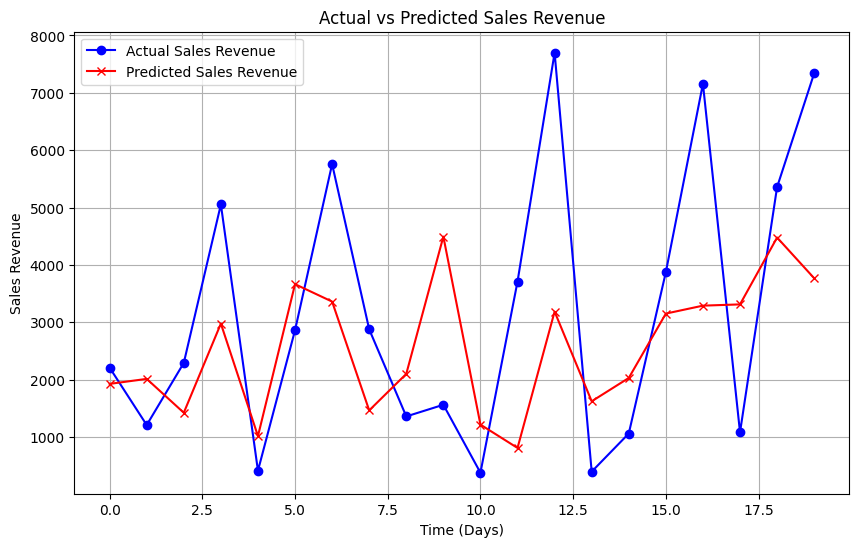

Predicted Sales Revenue for the next day: 3767.8315


In [28]:
def train_and_evaluate_model(df_processed):
    X = df_processed.drop(['Sales_Revenue'], axis=1) 
    y = df_processed['Sales_Revenue']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)


    y_pred = lgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')


    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Sales Revenue', marker='o', color='b')
    plt.plot(y_pred, label='Predicted Sales Revenue', marker='x', color='r')
    plt.title('Actual vs Predicted Sales Revenue')
    plt.xlabel('Time (Days)')
    plt.ylabel('Sales Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Predict the next day's sales revenue (for the day after the last date in the test set)
    last_known_data = X_test.iloc[-1:].copy()  # Get the last 7 days of data
    next_day_pred = lgb_model.predict(last_known_data)
    print(f'Predicted Sales Revenue for the next day: {next_day_pred[0]:.4f}')


train_and_evaluate_model(df_lagged)

